In [1]:
cd ../src

/home/richard/Desktop/software/epicluster-results_upload/epicluster-results/src


In [2]:
import numpy as np
import datetime
import random
import pandas
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import copy
import scipy.stats
import branchpro
import epicluster as ec

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
sigmas = [0.9, 0.5, 0.0]
thetas = [1e-4, 1e-1, 10]

# serial interval
serial_interval = pd.read_csv("../data/raw/covid_serial_interval.csv")
w = serial_interval['w']
w = w[:20]
w = w / sum(w)

# data
cases = pandas.read_csv('../data/covid/HK.csv')
imp_cases = cases['Imported_Cases']

a = 1
b = 5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(cases['Time'])),
        'Incidence Number': cases['Incidence_Number']
    }
)

imp_data = pd.DataFrame(
    {
        'Time': np.arange(len(cases['Time'])),
        'Incidence Number': cases['Imported_Cases']
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imp_data,
    epsilon=0.2,
    daily_serial_interval=w,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=7)
intervals7 = inference.get_intervals(central_prob=.9)

inference.run_inference(tau=0)
intervals0 = inference.get_intervals(central_prob=.9)

cases = cases['Incidence_Number']


past_cases = np.zeros(len(w))
forward_cases = copy.deepcopy(np.asarray(inc_data['Incidence Number']))
inf_cases = np.concatenate([past_cases, forward_cases])

imp_cases = np.asarray(imp_data['Incidence Number'])
imp_cases = np.concatenate([past_cases, imp_cases])


In [5]:

results = []
values = []
for sigma in sigmas:
    for theta in thetas:
        # run change point
        p = ec.PoissonModel(copy.deepcopy(inf_cases), w, imported_cases=imp_cases, epsilon=0.2, hyper_sigma=sigma, hyper_theta=theta)
        mcmc = ec.MCMCSampler(p, 2)
        phi_chain, z_chain, counts = mcmc.run_mcmc(Rhat_thresh=1.05, progress=True)

        results.append([phi_chain, z_chain])
        values.append((sigma, theta))



Iter=50, Rhat=39.52790535122373
Iter=100, Rhat=15.557020229973913
Iter=150, Rhat=13.932343447189945
Iter=200, Rhat=11.307627641226379
Iter=250, Rhat=7.547988120830028
Iter=300, Rhat=5.017079216266128
Iter=350, Rhat=5.5587421569047315
Iter=400, Rhat=3.172725654903131
Iter=450, Rhat=2.7039702473205858
Iter=500, Rhat=3.029535329646663
Iter=550, Rhat=1.999268543577631
Iter=600, Rhat=1.9532711598453938
Iter=650, Rhat=1.911596030619675
Iter=700, Rhat=1.8183170213667081
Iter=750, Rhat=1.7216430674687297
Iter=800, Rhat=1.5460342041832247
Iter=850, Rhat=1.4734031612205631
Iter=900, Rhat=1.4279322343210812
Iter=950, Rhat=1.455552662991956
Iter=1000, Rhat=1.5594784962567447
Iter=1050, Rhat=1.6406530394906667
Iter=1100, Rhat=1.6168954874744104
Iter=1150, Rhat=1.5745275745500549
Iter=1200, Rhat=1.519862552093948
Iter=1250, Rhat=1.4364920284132154
Iter=1300, Rhat=1.2638308188388951
Iter=1350, Rhat=1.236597294217082
Iter=1400, Rhat=1.216127188527958
Iter=1450, Rhat=1.2802276877589862
Iter=1500, Rhat=

Iter=1100, Rhat=2.1300884402955114
Iter=1150, Rhat=2.1497360299951893
Iter=1200, Rhat=2.404410846807538
Iter=1250, Rhat=3.2221680683298386
Iter=1300, Rhat=7.356257751180481
Iter=1350, Rhat=2.7679401422210677
Iter=1400, Rhat=2.0759202874483678
Iter=1450, Rhat=1.744259991852236
Iter=1500, Rhat=1.5484578945341205
Iter=1550, Rhat=1.412466588059107
Iter=1600, Rhat=1.3192652509395837
Iter=1650, Rhat=1.2416240057158594
Iter=1700, Rhat=1.1805054755138842
Iter=1750, Rhat=1.1299764864694184
Iter=1800, Rhat=1.088080144238126
Iter=1850, Rhat=1.0522611441709206
Iter=1900, Rhat=1.022006969632255
Converged 1900 1.022006969632255
Iter=50, Rhat=11.923285003501563
Iter=100, Rhat=7.722079348299037
Iter=150, Rhat=3.9164753175822486
Iter=200, Rhat=1.637924314425679
Iter=250, Rhat=1.669709172554201
Iter=300, Rhat=1.6927839999072816
Iter=350, Rhat=1.523946132681212
Iter=400, Rhat=1.0956518819160217
Iter=450, Rhat=1.0534045187678984
Iter=500, Rhat=1.1108058651959742
Iter=550, Rhat=1.0229340104891944
Converged

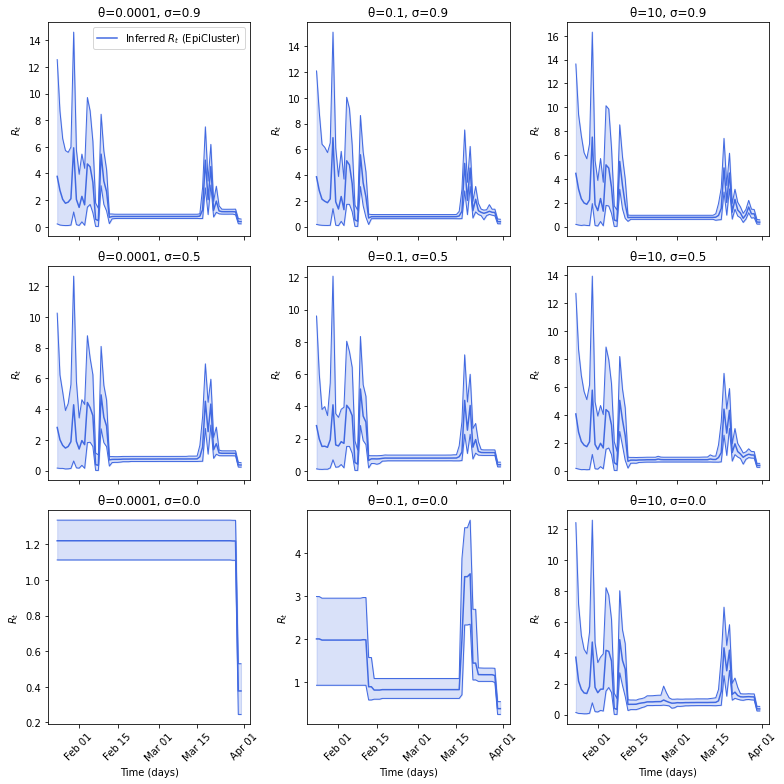

In [6]:
fig = plt.figure(figsize=(11,11))

num_exps = len(thetas) * len(sigmas)

for i in range(num_exps):
    date0 = (2020, 1, 23)
    x = np.arange(len(cases))
    x_dates = [datetime.datetime(*date0)]
    for xi in x[1:]:
        x_dates.append(x_dates[0] + datetime.timedelta(int(xi)))
    x = x_dates
    
    
    phi_chain, z_chain = results[i]
    
    ax = fig.add_subplot(len(thetas), len(sigmas), 1+i)

    sd = 1
    
    Rs = []
    num_mcmc = len(z_chain)
    for phi, z in zip(phi_chain[num_mcmc//4:], z_chain[num_mcmc//4:]):
        Rs.append([phi[zi] for zi in z][sd:])
        
    ax.plot(x[sd:], np.mean(Rs, axis=0), color='royalblue', label='Inferred $R_t$ (EpiCluster)')
    ax.fill_between(x[sd:], np.percentile(Rs, 5, axis=0), np.percentile(Rs, 95, axis=0), color='royalblue', alpha=0.2)
    ax.plot(x[sd:], np.percentile(Rs, 5, axis=0), color='royalblue', lw=1)
    ax.plot(x[sd:], np.percentile(Rs, 95, axis=0), color='royalblue', lw=1)
    
    if i == 0:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    
    ax.set_title('θ={}, σ={}'.format(values[i][1], values[i][0]))

    
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, ha='center')
    fig.autofmt_xdate(rotation=45, ha='center')
    
fig.set_tight_layout(True)


plt.savefig('../notebooks/FigureS6.pdf')
plt.show()
